In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from tqdm import tqdm
import random
import time

In [2]:
CSM_dir = '/'.join(os.getcwd().split('/')[:-1])
os.chdir(CSM_dir)
sys.path.append(CSM_dir+'/code')

In [3]:
from oligo_design import *

# overview

1) **select sgRNA spacer pairs** - In this example, we will import a CRISPick output file and pair guides targeting the same gene

2) **iBAR pairs** - In this example, we will use one strategy that guarantees edit correction for all individual barcodes.

3) **tRNA selection** (random assignment)

4) **generate oligos**

## select sgRNA spacer pairs

In [4]:
guide_input_df = pd.read_table('input_files/ecdf2fd1-327d-4423-ad71-69247ccfff95-sgrna-designs.txt')
pd.set_option('display.max_columns', 100)

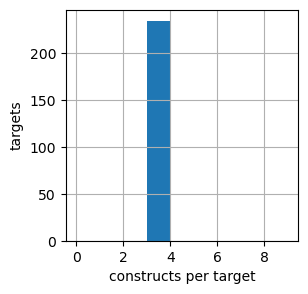

In [5]:
guide_pairs_df = pair_guides_single_target_CRISPick(guide_input_df, constructs_per_gene=3, pairing_method='pick_sum')

plt.figure(figsize=(3,3))
guide_pairs_df.value_counts('target').hist(bins=range(0,10))
plt.xlabel('constructs per target')
plt.ylabel('targets')
plt.show()

# select iBAR sequences

### There are multiple ways to encode information in iBARs. 
iBARs could encode identical sequences in both positions within a construct for simplicity. Or iBARs could be designed for maximum decoding efficiency relying on multiplexed detection. 

### Here, we implement one approach that seeks to balance several performance tradeoffs:

#### 1) all iBARs are unique (iBARs are not repeated in either position)
- the readout of either iBAR alone is sufficient to uniquely identify constructs; the readout of both iBARs is *not* required to uniquely identify constructs
    
#### 2) there is a guaranteed edit distance between all iBARs in a library
- edit distance 2: error detection
- edit distance 3: error correction
   
#### 3) multiplexed detection enables recombination detection
- detection of both iBARs enables detection of all recombination events, with the same per-barcode edit distance guarantees

#### 4) multiplexed detection may enable more efficient decoding
- detection of both iBARs may enable decoding in fewer cycles, but *without* edit distance guarantees
- detection of both iBARs enables detection of most recombination events in 0-1 additional cycles

#### 5) iBAR position is encoded in the first base identity
- reads can be mapped to iBAR position (1 or 2) based on the identity of the first iBAR base
- iBAR1 starts with 'A' or 'G'
- iBAR2 starts with 'C' or 'T'

#### 6) compatibility with clonal barcoding
- as iBAR1 alone is sufficient to identify a construct, iBAR2 may be substituted for a clonal barcode during oligo pool amplification
- degenerate primers for iBAR2 randomization may be designed to maintain iBAR position encoding via first base identity

## pre-computed barcode sets

- barcodes within a set have a guaranteed edit distance of 2 (error detection) or 3 (error correction)

- barcodes are not necessarily compatible across these sets

- these sets were designed with the dna-barcodes repository (https://github.com/feldman4/dna-barcodes) and we recommend this tool for the generation of additional barcode sets

In [6]:
# import all the barcode sets:
df_bc_sets = pd.DataFrame()
search = 'designed_barcode_sets/barcodes_n*_k*_*.noBsmBI.csv'
for file in glob(search):
    df_barcodes = pd.read_csv(file)
    df_bc_sets.loc[file, 'length'] = df_barcodes['n'][0]
    df_bc_sets.loc[file, 'distance'] = df_barcodes['k'][0]
    df_bc_sets.loc[file, 'metric'] = file.split('_')[-1].split('.')[0]
    df_bc_sets.loc[file, 'n_barcodes'] = len(df_barcodes)

df_bc_sets.sort_values('n_barcodes')

,length,distance,metric,n_barcodes
designed_barcode_sets/barcodes_n6_k3_Levenshtein.noBsmBI.csv,6.0,3.0,Levenshtein,87.0
designed_barcode_sets/barcodes_n7_k3_Levenshtein.noBsmBI.csv,7.0,3.0,Levenshtein,230.0
designed_barcode_sets/barcodes_n8_k3_Levenshtein.noBsmBI.csv,8.0,3.0,Levenshtein,835.0
designed_barcode_sets/barcodes_n6_k2_Levenshtein.noBsmBI.csv,6.0,2.0,Levenshtein,883.0
designed_barcode_sets/barcodes_n7_k2_Levenshtein.noBsmBI.csv,7.0,2.0,Levenshtein,1991.0
designed_barcode_sets/barcodes_n9_k3_Levenshtein.noBsmBI.csv,9.0,3.0,Levenshtein,3054.0
designed_barcode_sets/barcodes_n10_k3_Levenshtein.noBsmBI.csv,10.0,3.0,Levenshtein,10644.0
designed_barcode_sets/barcodes_n8_k2_Levenshtein.noBsmBI.csv,8.0,2.0,Levenshtein,12606.0
designed_barcode_sets/barcodes_n9_k2_Levenshtein.noBsmBI.csv,9.0,2.0,Levenshtein,42534.0
designed_barcode_sets/barcodes_n12_k3_Levenshtein.noBsmBI.csv,12.0,3.0,Levenshtein,62679.0


In [7]:
### select the smallest compatible barcode set available with the desired edit distance

required_distance = 3 ## 2 for error detection, 3 for error correction

n_guide_pairs = len(guide_pairs_df)

df_bc_sets_subset = df_bc_sets[df_bc_sets['distance']==required_distance]
iBAR_pairs = None

while iBAR_pairs is None:

    selected_bc_file = df_bc_sets_subset[df_bc_sets_subset.n_barcodes > 2*n_guide_pairs].iloc[
        df_bc_sets_subset[df_bc_sets_subset.n_barcodes > 2*n_guide_pairs]['n_barcodes'].argmin()].name 
    
    df_barcodes = pd.read_csv(selected_bc_file)
    
    print('Edit distance %s in %s cycles:\n'%(df_barcodes['k'][0],df_barcodes['n'][0]))
    
    iBAR_pairs = complete_iBARs(df_barcodes, n_guide_pairs, method='positional')
    
    if iBAR_pairs is None:
        df_bc_sets_subset = df_bc_sets_subset[df_bc_sets_subset.index != selected_bc_file]
        print('\nTrying again with next smallest barcode set.\n')
    if len(df_bc_sets_subset)==0:
        print('ran out of barcode files')

Edit distance 3 in 9 cycles:


generating and filtering complete iBARs...


100%|█████████████████████████████████████| 3054/3054 [00:00<00:00, 5490.03it/s]



optimizing barcode pairing...
attempt 1/3


100%|█████████████████████████████████████| 896/896 [00:00<00:00, 252662.12it/s]



designed 895 barcode pairs

determining cycling requirements for decoding...

barcode 1 is unique in set(barcode 1) in:
 7 cycles

barcode 2 is unique in set(barcode 2) in:
 7 cycles

barcodes in set(barcode 1, barcode 2) are unique in:
 7 cycles

simulating recombination detection...



barcode pair is unique in set(1-2, 2-1) in :
 3 cycles with 0% recombination detection
 or:
 4 cycles with 93% recombination detection

simulating recombination detection...



barcode pair is unique in set(1-2) in:
 3 cycles with 0% recombination detection
 or:
 4 cycles with 92% recombination detection


In [8]:
library_design_df = guide_pairs_df.merge(iBAR_pairs, left_index=True, right_index=True)
library_design_df

,target,target_symbol,spacer_1,spacer_2,spacer_1_pick_order,spacer_2_pick_order,target_version,iBAR_1,iBAR_2
0,323.0,APBB2,GAGAACGCACAGCAAAACAC,ACTGGGGTCCGGGTTAACAG,6,1,1,GCGAGTTCGGTG,TATCGCGCTTGG
1,323.0,APBB2,CACAGCTCGAGGAATCCTGT,ACATTGCCGGGACCTATTAT,5,2,2,AAACCCGCACGC,CAACAGTGTTCC
2,323.0,APBB2,ATATGCACTAACTAACATCC,AGAACCGAGGCAATCACCAT,3,4,3,AACGGATACAGG,CTACCGGGTGAG
3,393.0,ARHGAP4,AAAGAGTCTCTGGTTATACT,AGCATGCACCTCGAGAACCT,6,1,1,AATCTACTGTCA,CGGTATACGGCT
4,393.0,ARHGAP4,GGAGCACCAAAGCTTCCGGT,GCAGGCCAAGAAGACGTACC,2,5,2,GATACATCCGCG,TATGGGACTTAG
...,...,...,...,...,...,...,...,...,...
700,644672.0,CLDN25,GGAGCAGACCCAGCCAAGGA,GCCCATGGGAGGCTACCATG,5,2,2,ATGCCGGCAAAG,CTCGCACCTGTA
701,644672.0,CLDN25,GGAGGTCTGCGTGGATCGAG,TCAGATGGGTATTCAAGAGG,4,3,3,ACTAAGCAAGTG,TAAGGATCATGA
702,100190949.0,C5orf52,ACCCGAGATAAATGGCTCTT,AACTACCAGCGCGATAGACT,6,1,1,AGGTGAACCGAA,TCCCTAATGAGC
703,100190949.0,C5orf52,GACCAGGGATCCTCCACGAT,GAATAATCACCCGAGATAAA,5,2,2,AAATGGATGGCC,CACTAATGCAGG


## select tRNAs at random

In [9]:
tRNA_assignments = []
for tRNA in ['tRNA_A','tRNA_P','tRNA_Q']:
    tRNA_assignments += [tRNA for i in range(np.ceil(len(library_design_df)/3).astype(int))]
random.shuffle(tRNA_assignments)
tRNA_assignments = tRNA_assignments[:len(library_design_df)]

library_design_df['tRNA'] = tRNA_assignments
library_design_df

,target,target_symbol,spacer_1,spacer_2,spacer_1_pick_order,spacer_2_pick_order,target_version,iBAR_1,iBAR_2,tRNA
0,323.0,APBB2,GAGAACGCACAGCAAAACAC,ACTGGGGTCCGGGTTAACAG,6,1,1,GCGAGTTCGGTG,TATCGCGCTTGG,tRNA_P
1,323.0,APBB2,CACAGCTCGAGGAATCCTGT,ACATTGCCGGGACCTATTAT,5,2,2,AAACCCGCACGC,CAACAGTGTTCC,tRNA_Q
2,323.0,APBB2,ATATGCACTAACTAACATCC,AGAACCGAGGCAATCACCAT,3,4,3,AACGGATACAGG,CTACCGGGTGAG,tRNA_A
3,393.0,ARHGAP4,AAAGAGTCTCTGGTTATACT,AGCATGCACCTCGAGAACCT,6,1,1,AATCTACTGTCA,CGGTATACGGCT,tRNA_P
4,393.0,ARHGAP4,GGAGCACCAAAGCTTCCGGT,GCAGGCCAAGAAGACGTACC,2,5,2,GATACATCCGCG,TATGGGACTTAG,tRNA_Q
...,...,...,...,...,...,...,...,...,...,...
700,644672.0,CLDN25,GGAGCAGACCCAGCCAAGGA,GCCCATGGGAGGCTACCATG,5,2,2,ATGCCGGCAAAG,CTCGCACCTGTA,tRNA_A
701,644672.0,CLDN25,GGAGGTCTGCGTGGATCGAG,TCAGATGGGTATTCAAGAGG,4,3,3,ACTAAGCAAGTG,TAAGGATCATGA,tRNA_P
702,100190949.0,C5orf52,ACCCGAGATAAATGGCTCTT,AACTACCAGCGCGATAGACT,6,1,1,AGGTGAACCGAA,TCCCTAATGAGC,tRNA_A
703,100190949.0,C5orf52,GACCAGGGATCCTCCACGAT,GAATAATCACCCGAGATAAA,5,2,2,AAATGGATGGCC,CACTAATGCAGG,tRNA_Q


## generate oligos

In [10]:
# import dialout primer sequences
df_dialout = pd.read_csv('input_files/kosuri_dialout_primers.csv')
# dialout primers are truncated to 14 nt to keep total oligo length within 300 nt
df_dialout['fwd_short'] = df_dialout['fwd'].str.slice(-14)
df_dialout['rev_short'] = df_dialout['rev'].str.slice(-14)

In [11]:
# here we encode all members under the same dialout primer pair
# sublibraries can be encoded within an order with different dialout primer pairs
library_design_df['dialout']=0

In [12]:
library_design_df['dialout_fwd'] = library_design_df['dialout'].map(df_dialout['fwd_short'])
library_design_df['dialout_rev'] = library_design_df['dialout'].map(df_dialout['rev_short'])
library_design_df

,target,target_symbol,spacer_1,spacer_2,spacer_1_pick_order,spacer_2_pick_order,target_version,iBAR_1,iBAR_2,tRNA,dialout,dialout_fwd,dialout_rev
0,323.0,APBB2,GAGAACGCACAGCAAAACAC,ACTGGGGTCCGGGTTAACAG,6,1,1,GCGAGTTCGGTG,TATCGCGCTTGG,tRNA_P,0,CCGGCCAACATACC,CTCGTTCCTTTCGA
1,323.0,APBB2,CACAGCTCGAGGAATCCTGT,ACATTGCCGGGACCTATTAT,5,2,2,AAACCCGCACGC,CAACAGTGTTCC,tRNA_Q,0,CCGGCCAACATACC,CTCGTTCCTTTCGA
2,323.0,APBB2,ATATGCACTAACTAACATCC,AGAACCGAGGCAATCACCAT,3,4,3,AACGGATACAGG,CTACCGGGTGAG,tRNA_A,0,CCGGCCAACATACC,CTCGTTCCTTTCGA
3,393.0,ARHGAP4,AAAGAGTCTCTGGTTATACT,AGCATGCACCTCGAGAACCT,6,1,1,AATCTACTGTCA,CGGTATACGGCT,tRNA_P,0,CCGGCCAACATACC,CTCGTTCCTTTCGA
4,393.0,ARHGAP4,GGAGCACCAAAGCTTCCGGT,GCAGGCCAAGAAGACGTACC,2,5,2,GATACATCCGCG,TATGGGACTTAG,tRNA_Q,0,CCGGCCAACATACC,CTCGTTCCTTTCGA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,644672.0,CLDN25,GGAGCAGACCCAGCCAAGGA,GCCCATGGGAGGCTACCATG,5,2,2,ATGCCGGCAAAG,CTCGCACCTGTA,tRNA_A,0,CCGGCCAACATACC,CTCGTTCCTTTCGA
701,644672.0,CLDN25,GGAGGTCTGCGTGGATCGAG,TCAGATGGGTATTCAAGAGG,4,3,3,ACTAAGCAAGTG,TAAGGATCATGA,tRNA_P,0,CCGGCCAACATACC,CTCGTTCCTTTCGA
702,100190949.0,C5orf52,ACCCGAGATAAATGGCTCTT,AACTACCAGCGCGATAGACT,6,1,1,AGGTGAACCGAA,TCCCTAATGAGC,tRNA_A,0,CCGGCCAACATACC,CTCGTTCCTTTCGA
703,100190949.0,C5orf52,GACCAGGGATCCTCCACGAT,GAATAATCACCCGAGATAAA,5,2,2,AAATGGATGGCC,CACTAATGCAGG,tRNA_Q,0,CCGGCCAACATACC,CTCGTTCCTTTCGA


In [13]:
# build the oligos
oligo_design_df, failed_designs_df = build_CROPseq_multi_one_step_oligos(library_design_df)
oligo_design_df['oligo_len'] = oligo_design_df['oligo'].str.len()

changed a tRNA from tRNA_Q to tRNA_A


In [14]:
if not failed_designs_df.empty:
    print('failed to design the following constructs:')
    display(failed_designs_df)
    sys.exit()

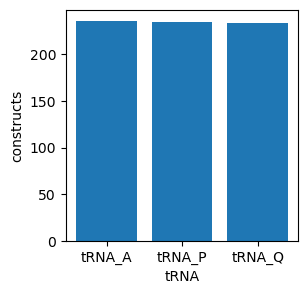

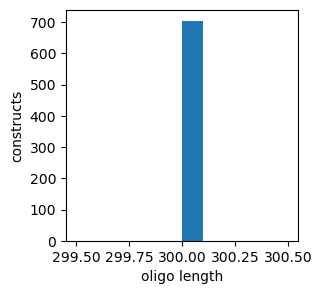

In [15]:
plt.figure(figsize=(3,3))
plt.bar(oligo_design_df.value_counts('tRNA').index, oligo_design_df.value_counts('tRNA').values)
plt.xlabel('tRNA')
plt.ylabel('constructs')
plt.show()

plt.figure(figsize=(3,3))
plt.hist(oligo_design_df.oligo_len)
plt.xlabel('oligo length')
plt.ylabel('constructs')
plt.show()

In [16]:
# oligo_design_df.to_csv('oligo_designs/CSM_library_design.%s.csv'%(time.strftime("%Y%m%d-%H%M%S")))
# oligo_design_df['oligo'].to_csv('oligo_designs/CSM_oligo_order.%s.csv'%(time.strftime("%Y%m%d-%H%M%S")))